# Glasgow GSP Demand Data Detrending
Graeme Hawker, University of Strathclyde, 9th August 2019

In [1]:
import zipfile
import pandas as pd
import datetime as dt
import numpy as np
import pytz
from scipy.signal import welch
from scipy.optimize import curve_fit
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import cm
from matplotlib.dates import DateFormatter
from matplotlib import rcParams
%matplotlib inline
plt.rcParams['figure.figsize'] = [11.60,16.53]
plt.rcParams['figure.dpi'] = 150 

In [2]:
def sp_to_dt(SD, SP, period_start=True):
    """
    Converts a settlement date and settlement period to a timezone-aware
    datetime object
    Parameters
    ----------
    SD : datetime.date object
        the settlement date
    SP : int
        the settlement period (in range 1 to 50)
    period_start : bool
        whether the desired datetime object should relate to the start (True)
        or end (False) of the settlement period
    Returns
    -------
    datetime : datetime.datetime
        a timezone-aware datetime object
    """
    #check date object passed - not datetime
    if not isinstance(SD, dt.date):
        raise ValueError('Expected Settlement Date parameter not of type datetime.date')

    #minimum SP value check
    if SP < 1:
        raise ValueError('SP value of %d less than minimum value of 1' % SP)

    #maximum SP value check, taking into account transition days
    transition_days = [dt.date(x.year, x.month, x.day)
                       for x in pytz.timezone('Europe/London')._utc_transition_times]
    if SD in transition_days[::2]: #clocks go forward
        if SP > 46:
            raise ValueError('SP value of %d exceeds maximum value of 46 \
                             for forward clock change date' % SP)
    elif SD in transition_days[1::2]: #clocks go back
        if SP > 50:
            raise ValueError('SP value of %d exceeds maximum value of 50 \
                             for backward clock change date' % SP)
    elif SP > 48:
        raise ValueError('SP value of {} exceeds maximum value of 48 for \
                         non-clock change date {}'.format(SP, SD))

    datetime = dt.datetime(SD.year, SD.month, SD.day, tzinfo=pytz.utc)
    datetime += dt.timedelta(minutes=(SP-1)*30)
    if not period_start:
        datetime += dt.timedelta(minutes=30)

    # DST shift should only be applied on days after transition day
    # (as does not impact calculation until SP resets to 1)
    if SD in transition_days[::2]:
        pass
    elif SD in transition_days[1::2] and SP > 2:
        datetime -= dt.timedelta(hours=1)
    else:
        datetime -= datetime.astimezone(pytz.timezone('Europe/London')).dst()
    return datetime

In [3]:
#detrending functions

#function to be fitted to annual data - 3 sinusoidal terms with base angular frequency of 1/2 hour and two harmonics
def annualTrend(t,a0,a1,a2,a3,c1,c2,c3):
    if type(t) is dt.datetime:
        t = (t-dt.datetime(t.year,1,1)).total_seconds()/3600  #convert datetime object into hours since start of year
    b1 = 2.0*np.pi/(24.0*365.0*2.0)
    b2 = 2.0*b1
    b3 = 3.0*b1
    return a0+a1*np.sin(b1*t+c1)+a2*np.sin(b2*t+c2)+a3*np.sin(b3*t+c3)
    
#function to be fitted to daily residuals - 2 sinusoidal terms with base angular frequency of 1/2 hour and single harmonic  
def diurnalTrend(t,a0,a1,a2,c1,c2):
    if type(t) is pd.Timestamp:
        t = t.hour
    b1 = 2.0*np.pi/(24.0*2.0)
    b2 = 2.0*b1
    return a0+a1*np.sin(b1*t+c1)+a2*np.sin(b2*t+c2)
    
#season definitions by month    
def getSeason(timestamp):
    if timestamp.month <=3:
        return 0
    elif timestamp.month <=6:
        return 1
    elif timestamp.month <=9:
        return 2
    return 3
    
#wrapper to allow diurnal value to be returned without separately calculating season    
def diurnalTrendWithSeason(t,coefficients):
    return diurnalTrend(t,*coefficients[getSeason(t)])
    
#wrapper to curve fitting function to return annual trend coefficients
def getAnnualCoefficients(timeseries):
    timeseries = timeseries.dropna()
    integerIndex=np.arange(len(timeseries))
    Apopt, Apcov = curve_fit(annualTrend, integerIndex, timeseries, p0=np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1]))
    return Apopt    
    
#wrapper to curve fitting function to return diurnal trend coefficients
def getDiurnalTrendCoefficients(timeseries):
    timeseries = timeseries.dropna()
    Dpopt, Dpcov = curve_fit(diurnalTrend, np.arange(24), timeseries, p0=np.array([0.1,0.1,0.1,0.1,0.1]))
    return Dpopt

In [4]:
#paths
GSP_data_path = '/Users/graeme/Downloads/P114_gsp_data.zip'

In [5]:
#list all GSPs in a given GSP group area
GSP_area = 'N'
with zipfile.ZipFile(GSP_data_path) as z:
    with z.open('{}_gsp_data.csv'.format(GSP_area)) as f:
        raw_data = pd.read_csv(f)
        
raw_data['gsp_id'].unique()

array(['AYRR', 'BAIN', 'BROX', 'CAFA', 'CATY', 'CHAS', 'COAT', 'COCK',
       'CURR', 'DEVM', 'DEVO', 'DRCR', 'DRUM', 'DUMF', 'DUNB', 'ELDE',
       'GIFF', 'GLLE', 'GLLU', 'GLNI', 'GLRO', 'HAGR', 'HAWI', 'HELE',
       'HUER', 'KEOO', 'KILB', 'KILS', 'KILW', 'LEVE', 'PAIS', 'PART',
       'POOB', 'SACO', 'SANX', 'SHRU', 'SPAV', 'STIR', 'STLE', 'TONG',
       'WFIE', 'WGEO', 'WHHO', 'WISH', 'BAGA', 'BERW', 'BONN', 'BRAP',
       'CHAP', 'CLYM', 'COYL', 'CROO', 'CUMB', 'CUPA', 'DEWP', 'DUNF',
       'EAST', 'ECCL', 'EERH', 'EKIL', 'EKIS', 'ERSK', 'GALA', 'GORG',
       'GOVA', 'GRMO', 'INKE', 'JOHN', 'KAIM', 'KIER', 'KILT', 'LING',
       'LINM', 'MAYB', 'NEAR', 'NETS', 'PORD', 'RAVE', 'REDH', 'SIGH',
       'STHA', 'TELR', 'TOWH', 'ABNELVF', 'DFIN', 'KILN', 'DRYM', 'DALM3',
       'FINN'], dtype=object)

In [6]:
#GSPs and date range to select
#GSPs = ['A_ELST_1', 'P_MYBS_P', 'L_INDQ1', 'L_LAND1', 'L_ABHA1', 'L_EXET1']
#GSPs = ['N_FINN', 'N_GOVA', 'N_PART', 'N_SANX', 'N_WGEO', 'N_CHAS', 'N_PORD', 'N_BRAP'] # Glasgow GSPs
GSPs = ['DRUM', 'KIER', 'PORD', 'PART', 'FINN', 'WGEO', 'GOVA', 'DEVM', 'HAGR', 'STHA',
       'SANX', 'EERH', 'CHAS', 'CATY', 'CLYM'] #missing: WIYH, DALM
start_date, end_date = dt.date(2009,1,1), dt.date(2019,1,1)
assert([i for i in GSPs if i not in raw_data['gsp_id'].unique()]==[]) #check if required GSPs in dataset
GSPs = ['N_'+i for i in GSPs]
GSPs

['N_DRUM',
 'N_KIER',
 'N_PORD',
 'N_PART',
 'N_FINN',
 'N_WGEO',
 'N_GOVA',
 'N_DEVM',
 'N_HAGR',
 'N_STHA',
 'N_SANX',
 'N_EERH',
 'N_CHAS',
 'N_CATY',
 'N_CLYM']

In [7]:
#set up blank dataframe
rawTimeSeries = pd.DataFrame(columns=['timestamp']+GSPs)
rawTimeSeries['timestamp'] = pd.DatetimeIndex(start=start_date,end=end_date,freq='30T')
rawTimeSeries.set_index('timestamp', inplace=True)

#fetch data for each GSP and overwrite values in dataframe
for GSP in GSPs:
    print(GSP)
    with zipfile.ZipFile(GSP_data_path) as z:
        with z.open('{}_gsp_data.csv'.format(GSP.split('_')[0])) as f:
            raw_data = pd.read_csv(f)
            gsp_data = raw_data[raw_data.gsp_id=='_'.join(GSP.split('_')[1:])][['settlement_date', 'settlement_period', 'meter_volume']]
            gsp_data['timestamp'] = gsp_data.apply(lambda row: sp_to_dt(dt.date(int(str(row['settlement_date'])[:4]),
                                                                                    int(str(row['settlement_date'])[4:6]),
                                                                                    int(str(row['settlement_date'])[6:8])),
                                                                        row['settlement_period'], 
                                                                        period_start=True), axis=1)
            #gsp_data = gsp_data[['timestamp', 'meter_volume']].set_index('timestamp').sort_index()
            rawTimeSeries.update(gsp_data[['timestamp', 'meter_volume']].set_index('timestamp').sort_index().rename(columns={'meter_volume':GSP}).tz_convert(None))
rawTimeSeries = rawTimeSeries.convert_objects(convert_numeric=True)
rawTimeSeries = rawTimeSeries*2 # convert MWh/30mins to MW
rawTimeSeries

/Users/graeme/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  app.launch_new_instance()


N_DRUM
N_KIER
N_PORD
N_PART
N_FINN
N_WGEO
N_GOVA
N_DEVM
N_HAGR
N_STHA
N_SANX
N_EERH
N_CHAS
N_CATY
N_CLYM


/Users/graeme/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,N_DRUM,N_KIER,N_PORD,N_PART,N_FINN,N_WGEO,N_GOVA,N_DEVM,N_HAGR,N_STHA,N_SANX,N_EERH,N_CHAS,N_CATY,N_CLYM
timestamp,,,,,,,,,,,,,,,
2009-01-01 00:00:00,54.91,54.51,56.050,36.190,NaN,39.91,28.060,24.580,29.56,43.89,23.53,48.850,51.040,34.35,61.180
2009-01-01 00:30:00,53.64,55.20,57.070,35.520,NaN,39.94,27.420,29.890,29.83,44.17,23.61,47.180,51.550,34.05,61.130
2009-01-01 01:00:00,52.72,55.02,58.260,34.790,NaN,40.14,27.080,35.310,30.40,42.81,24.05,45.320,52.360,33.71,60.300
2009-01-01 01:30:00,50.44,53.38,57.360,33.790,NaN,39.71,26.590,34.380,30.03,41.31,23.39,43.730,51.320,32.48,57.590
2009-01-01 02:00:00,49.41,51.96,57.270,33.470,NaN,39.09,26.270,33.860,29.84,40.34,23.01,42.320,50.560,31.70,55.670
2009-01-01 02:30:00,47.94,50.67,56.260,33.140,NaN,38.63,25.830,33.480,29.04,39.21,22.34,40.930,50.020,30.91,53.780
2009-01-01 03:00:00,45.66,48.13,54.760,31.740,NaN,37.81,25.090,32.100,27.68,37.04,21.52,38.770,49.130,29.78,50.870
2009-01-01 03:30:00,43.20,46.25,52.890,30.450,NaN,37.30,24.240,30.290,26.23,35.11,21.49,37.050,48.220,29.57,48.960
2009-01-01 04:00:00,40.99,44.12,51.630,29.290,NaN,37.01,23.770,28.780,25.20,33.04,20.74,35.420,47.030,28.52,46.720


In [8]:
#perform fitting of annual trend function, store coefficients in dataframe
print("Fitting annual trends...")
annualCoeffsDF = rawTimeSeries.apply(lambda x: pd.Series(getAnnualCoefficients(x)))
annualCoeffsDF.index = ['a0','a1','a2','a3','c1','c2','c3']
annualCoeffsDF

Fitting annual trends...


,N_DRUM,N_KIER,N_PORD,N_PART,N_FINN,N_WGEO,N_GOVA,N_DEVM,N_HAGR,N_STHA,N_SANX,N_EERH,N_CHAS,N_CATY,N_CLYM
a0,38.189126,40.109311,39.989739,28.672342,21.290804,39.541171,25.700746,19.836332,24.280216,26.142859,21.966090,43.958606,48.885527,23.213501,44.486756
a1,9.626930,-8.304760,-8.337679,-5.543470,-0.901300,-3.470057,-3.658699,4.013392,4.567333,-6.822657,4.267882,-8.413171,-5.819984,3.780423,8.790660
a2,-1.275664,0.252114,1.954120,-0.223189,0.731460,-0.872435,0.546744,0.189960,0.283958,-0.045114,0.652356,0.761690,0.448054,1.100976,0.644191
a3,0.477087,0.087358,0.460156,0.291204,0.553407,-0.601644,0.337502,-0.118167,0.399893,0.367852,-0.543415,-0.448624,1.017629,0.272896,0.200660
c1,38.945049,35.866499,23.078690,10.674240,4.837829,17.336025,17.106987,26.356950,26.316757,42.057709,26.166454,23.358042,23.269979,19.955253,26.428242
c2,3.934656,1.435153,-5.090096,0.686761,-7.576143,-35.222736,0.556884,-1.177148,-4.463952,0.450005,-2.320473,8.476130,0.419951,0.316902,0.629148
c3,4.249936,-1.682854,4.137780,-1.412661,2.797824,8.100609,-0.640081,-0.069610,-10.866220,0.725959,0.984981,6.956165,-1.267945,-0.107682,-0.917931


In [9]:
#create mirror of timeseries data with calculated annual components only
print("Generating annual components...")
annualComponentTimeSeries = pd.DataFrame(index=rawTimeSeries.index)
for column in annualCoeffsDF:
    columnData = pd.DataFrame([annualTrend(x,*annualCoeffsDF[column].values) 
                               for x in np.arange(len(rawTimeSeries.index))],
                              index=rawTimeSeries.index,
                              columns=['data'])
    annualComponentTimeSeries[column] = columnData.loc[:,['data']]
annualComponentTimeSeries.head()

Generating annual components...


,N_DRUM,N_KIER,N_PORD,N_PART,N_FINN,N_WGEO,N_GOVA,N_DEVM,N_HAGR,N_STHA,N_SANX,N_EERH,N_CHAS,N_CATY,N_CLYM
timestamp,,,,,,,,,,,,,,,
2009-01-01 00:00:00,47.794472,48.294044,48.802769,33.502987,21.668131,41.883608,29.393003,23.443865,29.181944,32.767536,24.702800,52.536823,53.670570,26.906117,53.166088
2009-01-01 00:30:00,47.795986,48.294828,48.804405,33.503540,21.667674,41.884187,29.393851,23.444279,29.182456,32.768650,24.702941,52.536737,53.671791,26.907767,53.167450
2009-01-01 01:00:00,47.797499,48.295612,48.806040,33.504093,21.667217,41.884767,29.394699,23.444693,29.182967,32.769763,24.703083,52.536651,53.673012,26.909417,53.168810
2009-01-01 01:30:00,47.799011,48.296394,48.807674,33.504646,21.666760,41.885347,29.395547,23.445107,29.183476,32.770875,24.703225,52.536563,53.674234,26.911065,53.170169
2009-01-01 02:00:00,47.800522,48.297175,48.809306,33.505198,21.666303,41.885928,29.396394,23.445519,29.183984,32.771986,24.703367,52.536475,53.675456,26.912714,53.171526


In [10]:
#create mirror of timeseries data with residuals (subtract annual components from raw time series data) 
print("Generating annual residuals...")
annualResiduals = rawTimeSeries.subtract(annualComponentTimeSeries)
annualResiduals.head()

Generating annual residuals...


,N_DRUM,N_KIER,N_PORD,N_PART,N_FINN,N_WGEO,N_GOVA,N_DEVM,N_HAGR,N_STHA,N_SANX,N_EERH,N_CHAS,N_CATY,N_CLYM
timestamp,,,,,,,,,,,,,,,
2009-01-01 00:00:00,7.115528,6.215956,7.247231,2.687013,NaN,-1.973608,-1.333003,1.136135,0.378056,11.122464,-1.172800,-3.686823,-2.630570,7.443883,8.013912
2009-01-01 00:30:00,5.844014,6.905172,8.265595,2.016460,NaN,-1.944187,-1.973851,6.445721,0.647544,11.401350,-1.092941,-5.356737,-2.121791,7.142233,7.962550
2009-01-01 01:00:00,4.922501,6.724388,9.453960,1.285907,NaN,-1.744767,-2.314699,11.865307,1.217033,10.040237,-0.653083,-7.216651,-1.313012,6.800583,7.131190
2009-01-01 01:30:00,2.640989,5.083606,8.552326,0.285354,NaN,-2.175347,-2.805547,10.934893,0.846524,8.539125,-1.313225,-8.806563,-2.354234,5.568935,4.419831
2009-01-01 02:00:00,1.609478,3.662825,8.460694,-0.035198,NaN,-2.795928,-3.126394,10.414481,0.656016,7.568014,-1.693367,-10.216475,-3.115456,4.787286,2.498474


In [11]:
#get hourly averages by season for annual residuals
print("Fitting diurnal trends...")
hourlySeasonalAverages = annualResiduals.groupby([getSeason,
                                                  annualResiduals.index.map(lambda t: t.hour)]).mean()
hourlySeasonalAverages.head()

Fitting diurnal trends...


N_DRUM     N_KIER     N_PORD    N_PART    N_FINN     N_WGEO  \
  timestamp                                                                   
0 0          -4.567745  -2.656032  -5.696096 -2.980332 -4.779711  -9.575325   
  1          -7.877670  -4.831291  -6.878329 -5.419233 -5.450662 -10.846989   
  2         -11.309212  -8.252567  -9.570012 -7.587672 -6.207928 -12.303743   
  3         -13.266548 -10.108966 -11.085328 -8.903554 -6.499032 -13.071265   
  4         -14.186532 -11.273178 -11.877453 -9.517949 -6.412691 -13.299565   

               N_GOVA    N_DEVM    N_HAGR    N_STHA    N_SANX     N_EERH  \
  timestamp                                                                
0 0         -3.393029 -1.695043 -2.497067 -2.426104 -2.357711  -9.289138   
  1         -4.546374  0.624314 -4.356995 -4.552349 -3.198098 -12.934266   
  2         -5.720691 -0.924467 -6.453528 -6.898887 -4.656343 -15.680407   
  3         -6.447209 -2.134060 -7.682426 -8.606608 -5.229165 -17.288306   
  4         -6.679250 -3.520236 -8.252781 -9.597592 -5.680700 -17.882035   

                N_CHAS    N_CATY     N_CLYM  
  timestamp                                  
0 0         -10.211021 -5.281148  -6.663368  
  1         -11.911197 -6.621646  -9.192919  
  2         -14.255727 -8.161510 -12.331724  
  3         -15.339353 -8.707406 -14.003456  
  4         -15.834843 -8.858799 -15.220242

In [12]:
#perform fitting of diurnal trend function, store coefficients in array
diurnalCoeffs = []
diurnalCoeffsDF = pd.DataFrame(index=['a0','a1','a2','c1','c2'])
for column in hourlySeasonalAverages.columns.values.tolist():
    nodeDiurnalCoeffs = []
    for season in hourlySeasonalAverages.index.levels[0]:
        Dpopt, Dpcov = curve_fit(diurnalTrend,
                                 np.arange(24),
                                 hourlySeasonalAverages.loc[season,:][column].values,
                                 p0=np.array([0.1,0.1,0.1,0.1,0.1]))
        nodeDiurnalCoeffs.append(Dpopt)
    diurnalCoeffs.append(nodeDiurnalCoeffs)
    diurnalCoeffsDF[column] = Dpopt
diurnalCoeffsDF

,N_DRUM,N_KIER,N_PORD,N_PART,N_FINN,N_WGEO,N_GOVA,N_DEVM,N_HAGR,N_STHA,N_SANX,N_EERH,N_CHAS,N_CATY,N_CLYM
a0,-6.564473,-5.012704,5.605924,-0.182299,2.294911,10.158933,4.783856,-0.968917,-2.316443,-0.601442,1.006169,-12.762231,9.224882,-1.131461,-12.774083
a1,-10.844521,-8.399618,9.217449,2.620431,4.330148,16.275262,7.581001,1.435490,-4.288022,1.378680,-1.996425,20.503799,-14.714157,2.478357,20.510551
a2,-6.257870,-5.351493,11.721582,-5.141787,-7.201167,-18.996604,-7.794995,-2.967281,-3.932823,-6.211576,-4.725992,-8.261135,-19.875099,-5.040812,-7.649400
c1,-15.998867,-16.035780,-2.946101,-70.575310,-9.105343,-9.294330,-2.906385,0.133341,-9.910751,-13.598665,-12.075282,-25.318189,-6.166386,-13.402929,-18.988448
c2,-6.243346,-6.266627,-1.913909,-36.810364,-23.691537,-11.140476,-4.845406,-12.015260,-5.913874,-43.104689,-36.688197,-18.945649,-162.030855,-17.868330,-12.939941


In [13]:
print("Generating diurnal components...")   
#create mirror of timeseries data with calculated diurnal components only
diurnalComponentTimeSeries = pd.DataFrame(index=rawTimeSeries.index)
for column,coefficients in zip(rawTimeSeries.columns.values.tolist(),
                               diurnalCoeffs):
    columnData = pd.DataFrame([diurnalTrendWithSeason(x,coefficients) for x in rawTimeSeries.index],
                              index=rawTimeSeries.index,
                              columns=['data'])
    diurnalComponentTimeSeries[column] = columnData.loc[:,['data']]
diurnalComponentTimeSeries.head()

Generating diurnal components...


,N_DRUM,N_KIER,N_PORD,N_PART,N_FINN,N_WGEO,N_GOVA,N_DEVM,N_HAGR,N_STHA,N_SANX,N_EERH,N_CHAS,N_CATY,N_CLYM
timestamp,,,,,,,,,,,,,,,
2009-01-01 00:00:00,-7.961678,-5.092157,-5.496904,-4.845302,-5.319188,-9.182944,-3.727441,-0.082637,-4.175986,-4.005214,-2.621238,-13.679296,-10.039269,-6.479101,-10.589959
2009-01-01 00:30:00,-7.961678,-5.092157,-5.496904,-4.845302,-5.319188,-9.182944,-3.727441,-0.082637,-4.175986,-4.005214,-2.621238,-13.679296,-10.039269,-6.479101,-10.589959
2009-01-01 01:00:00,-9.149036,-6.312108,-8.415134,-6.210256,-6.068187,-12.016916,-5.208686,-1.150937,-5.142395,-5.565486,-3.840589,-14.080609,-13.400706,-7.449785,-10.780646
2009-01-01 01:30:00,-9.149036,-6.312108,-8.415134,-6.210256,-6.068187,-12.016916,-5.208686,-1.150937,-5.142395,-5.565486,-3.840589,-14.080609,-13.400706,-7.449785,-10.780646
2009-01-01 02:00:00,-9.970982,-7.238848,-10.194760,-7.069182,-6.271980,-13.373911,-5.998989,-1.986183,-5.822985,-6.585437,-4.638835,-14.171516,-15.162639,-7.890318,-10.855593


In [14]:
print("Generating diurnal residuals...")
#create mirror of timeseries data with both annual and diurnal components removed    
detrendedTimeSeries = annualResiduals.subtract(diurnalComponentTimeSeries)
detrendedTimeSeries.head()

Generating diurnal residuals...


,N_DRUM,N_KIER,N_PORD,N_PART,N_FINN,N_WGEO,N_GOVA,N_DEVM,N_HAGR,N_STHA,N_SANX,N_EERH,N_CHAS,N_CATY,N_CLYM
timestamp,,,,,,,,,,,,,,,
2009-01-01 00:00:00,15.077206,11.308113,12.744135,7.532315,NaN,7.209337,2.394438,1.218772,4.554042,15.127678,1.448438,9.992473,7.408699,13.922984,18.603871
2009-01-01 00:30:00,13.805692,11.997328,13.762498,6.861761,NaN,7.238757,1.753589,6.528358,4.823530,15.406564,1.528296,8.322558,7.917479,13.621334,18.552510
2009-01-01 01:00:00,14.071537,13.036496,17.869094,7.496163,NaN,10.272149,2.893987,13.016244,6.359428,15.605722,3.187506,6.863958,12.087694,14.250369,17.911837
2009-01-01 01:30:00,11.790025,11.395714,16.967460,6.495610,NaN,9.841569,2.403139,12.085831,5.988919,14.104610,2.527364,5.274046,11.046472,13.018720,15.200478
2009-01-01 02:00:00,11.580460,10.901673,18.655454,7.033983,NaN,10.577983,2.872595,12.400664,6.479001,14.153451,2.945468,3.955041,12.047184,12.677604,13.354067


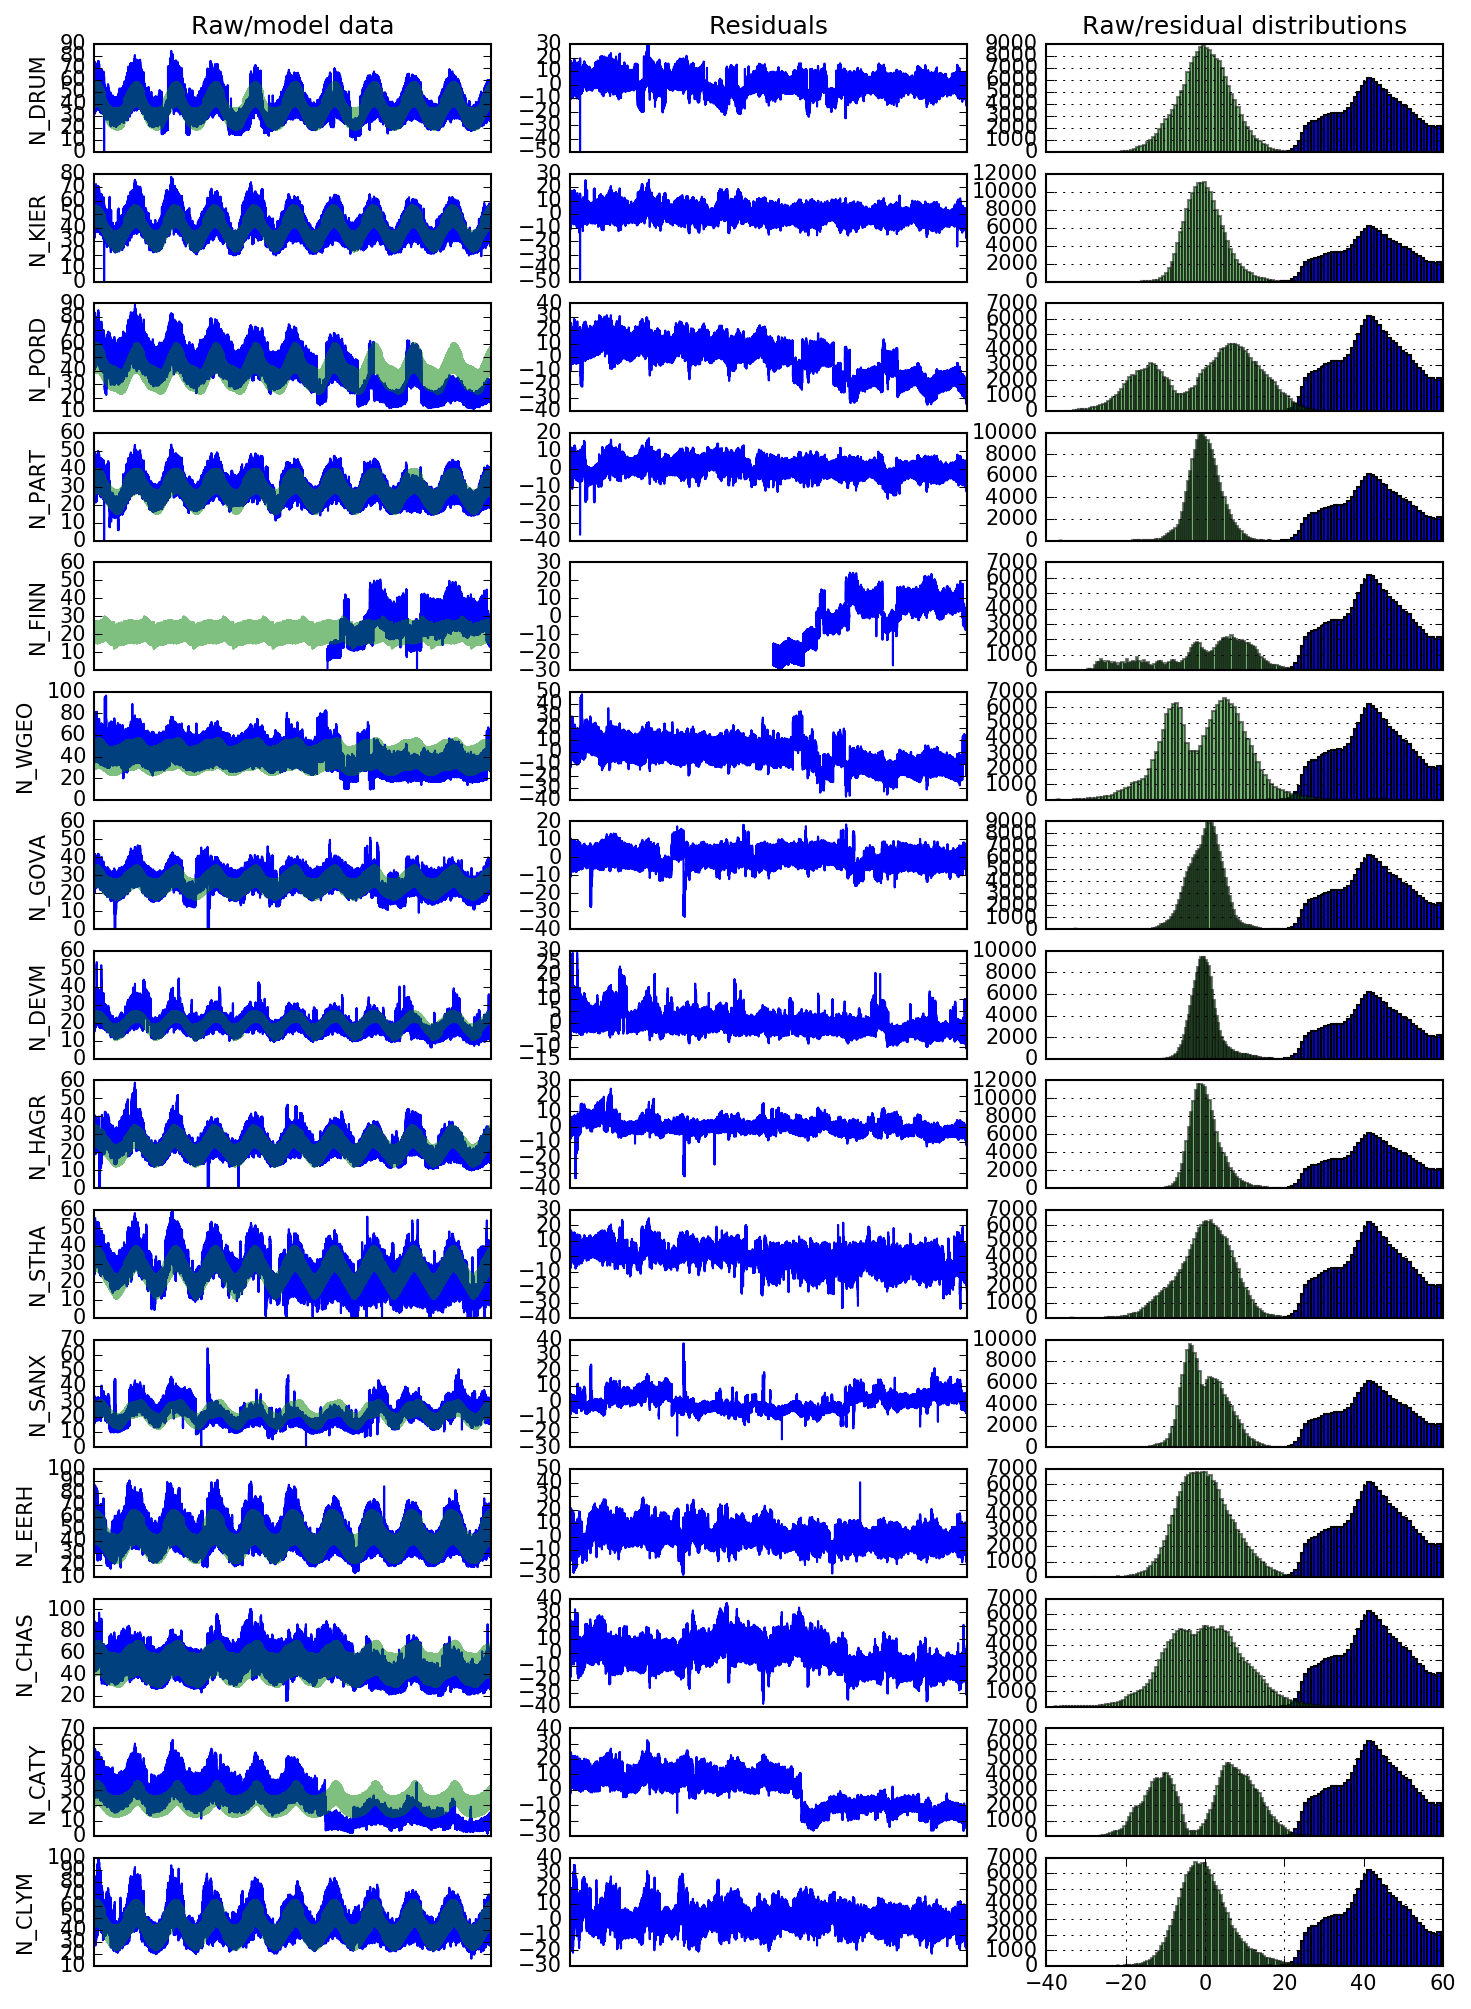

In [15]:
#generate plots for all GSPs
fig, axes = plt.subplots(nrows=len(GSPs), ncols=3)
#fig.autofmt_xdate()
#myFmt = DateFormatter("%y") 

for i in range(len(GSPs)):
    ax1 = rawTimeSeries[GSPs[i]].plot(ax=axes[i,0]) #raw data
    ax1.set_ylabel(GSPs[i])
    if i==0:
        ax1.title.set_text('Raw/model data')
    ax1.xaxis.set_visible(False)
    (annualComponentTimeSeries[GSPs[i]]+diurnalComponentTimeSeries[GSPs[i]]).plot(ax=ax1, alpha=0.5) #annual plus diurnal components
    ax2 = detrendedTimeSeries[GSPs[i]].plot(ax=axes[i,1])
    if i==0:
        ax2.title.set_text('Residuals')
    ax2.xaxis.set_visible(False)
    ax3 = rawTimeSeries[GSP].hist(bins=100, ax=axes[i,2])
    ax3 = detrendedTimeSeries[GSPs[i]].hist(bins=100, ax=ax3, alpha=0.5)
    ax3.set_xlim([-40, 60])
    if i==0:
        ax3.title.set_text('Raw/residual distributions')
    if i<len(GSPs)-1:
        ax3.xaxis.set_visible(False)
fig.savefig('glasgow_GSP_trends.pdf', dpi=fig.dpi)
    

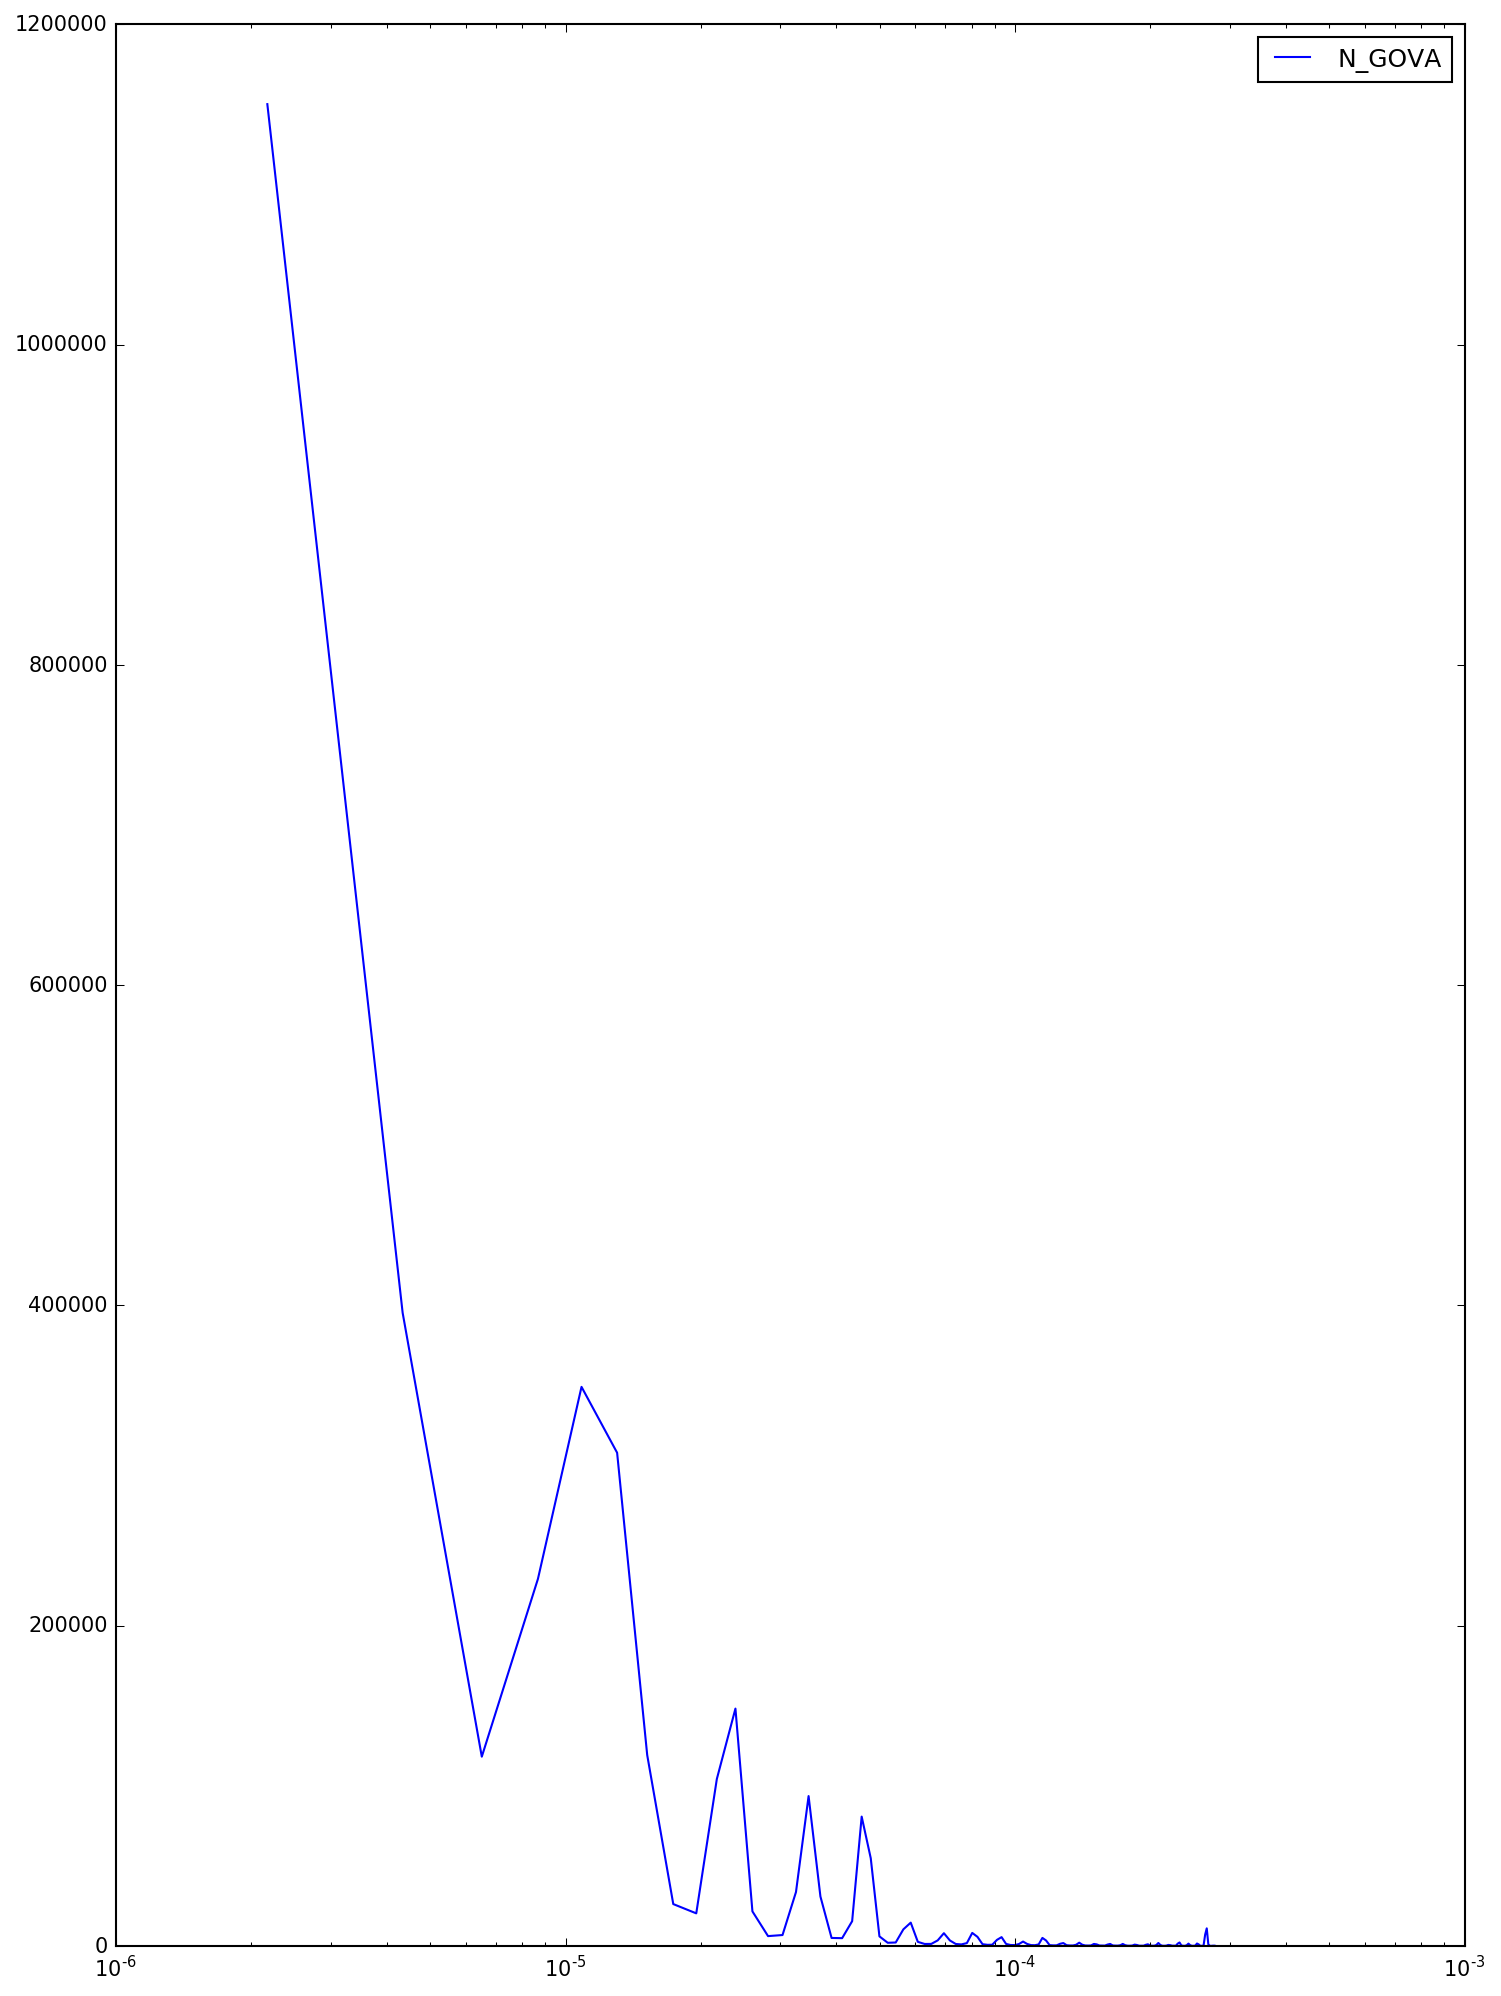

In [16]:
#look at power spectrum of residuals
GSP = 'N_GOVA'
f, psd = welch(detrendedTimeSeries[GSP].values,
               fs = 1/1800.0,
               window = 'hanning',
               detrend = 'constant')
plt.semilogx(f, psd, label=GSP)
plt.legend()

In [17]:
#test if detrended data is normal - if p-value is less than critical value (e.g. 0.05)
k2, p = stats.normaltest(detrendedTimeSeries[GSP])
p

0.0

In [22]:
#test if detrended data is stationary 
#https://machinelearningmastery.com/time-series-data-stationary-python/
#if ADF statistic is less than critical value then series has no unit root 
#i.e. can be considered stationary
for GSP in GSPs:
    print(GSP)
    result = adfuller(detrendedTimeSeries[GSP].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

N_DRUM
ADF Statistic: -14.953416
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_KIER
ADF Statistic: -19.910356
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_PORD
ADF Statistic: -9.970903
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_PART
ADF Statistic: -16.938225
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_FINN
ADF Statistic: -4.397033
p-value: 0.000300
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_WGEO
ADF Statistic: -17.855098
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_GOVA
ADF Statistic: -25.439792
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_DEVM
ADF Statistic: -17.436525
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_HAGR
ADF Statistic: -11.181274
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
N_STHA
ADF Statistic: -17.335917
p-value: 0.000000
Critic

In [21]:
detrendedTimeSeries['N_FINN']

timestamp
2014-02-14 00:00:00   -16.209575
2014-02-14 00:30:00   -16.210067
2014-02-14 01:00:00   -15.461560
2014-02-14 01:30:00   -15.462052
2014-02-14 02:00:00   -15.258752
2014-02-14 02:30:00   -15.259245
2014-02-14 03:00:00   -15.580080
2014-02-14 03:30:00   -15.580574
2014-02-14 04:00:00   -16.371329
2014-02-14 04:30:00   -16.371824
2014-02-14 05:00:00   -17.549390
2014-02-14 05:30:00   -17.549886
2014-02-14 06:00:00   -19.008423
2014-02-14 06:30:00   -19.008919
2014-02-14 07:00:00   -20.627508
2014-02-14 07:30:00   -20.628006
2014-02-14 08:00:00   -22.279259
2014-02-14 08:30:00   -22.279757
2014-02-14 09:00:00   -23.838790
2014-02-14 09:30:00   -23.839289
2014-02-14 10:00:00   -25.192444
2014-02-14 10:30:00   -25.192944
2014-02-14 11:00:00   -26.245666
2014-02-14 11:30:00   -26.246166
2014-02-14 12:00:00   -26.929481
2014-02-14 12:30:00   -26.929982
2014-02-14 13:00:00   -27.205156
2014-02-14 13:30:00   -27.205658
2014-02-14 14:00:00   -27.066700
2014-02-14 14:30:00   -27.067203
